# Acea Smart Water: EDA & modeling by LightGBM

## Contents

* [Introduction](#1)

* [Background for water resources](#2)

* [Visualization & EDA](#3)

 * [Data overview](#4)
 * [Visualize](#5)
 * [EDA](#6)

* [Modeling LightGBM](#7)

<a id="1"></a> <br>
# <div class="alert alert-block alert-success">Introduction</div>

## About this notebook

In this notebook, I'll explain dataset's background, check data, and create predicting model.

In this competition, we need to create a notebook for submission.However, in order to compile our notebook, we need to invent a story based on your knowledge of water sources, build a machine learning model, and verify its performance by setting your own evaluation criteria. I will provide an example analysis to help with this.

First, I will explain the prior knowledge needed to understand the data set. Next, I will take a look at the overview of the data set. If some of the locations are known, I will also check the map. Then, check the data in a graph. After that, I will try to check correlation and trend. Finally, I will try to create a model for predicting data using lightGBM. I will check its performance with graphs and RMSE, and also check which features are important.

-----------------

<a id="2"></a> <br>
# <div class="alert alert-block alert-success">Background for water resources</div>

To under stand dataset, I summary background knowledge of water resources.

Note! I refered contents of [SSWM Toolbox](https://sswm.info/) and [USGS](https://www.usgs.gov/). The illustrations have been borrowed from the respective pages and will be copyrighted according to the regulations.

## Where is earth's watere resorces?

There is an enormous amount of water on the earth. However, the available water resources are only a fraction of what they could be. Water supply company supply part of the available water resources to us as water supply.

<img src="https://github.com/tasotasoso/kaggle_media/blob/main/Acea%20Smart%20Water/EarthsWater-BarChart.png?raw=true" width="600">


About 71 percent of the Earth's surface is water-covered, and the oceans hold about 96.5 percent of all Earth's water. Water also exists in the air as water vapor, in rivers and lakes, in icecaps and glaciers, in the ground as soil moisture and in aquifers.

Above bar chart shows the rate where water exists. 

In the first bar, notice how only 2.5% of Earth's water is freshwater - the amount needed for life to survive.
The middle bar shows the breakdown of freshwater. Only a little more than 1.2% of all freshwater is surface water.
Aquifer is groundwater. River, lake and spring are surface fresh water.
The right bar shows the breakdown of surface freshwater. Most of this water is locked up in ice, and another 20.9% is found in lakes. Rivers make up 0.49% of surface freshwater.

Naturally, the sources of those freshwater supplies are also constantly changing, affected by precipitation and other factors. So it is important to predict their water amount to constant water supply. 

In this competition, 4 water resources are target to predict.

* lake

* river

* spring

* aquifer


Lakes and rivers are easy to imagine, but some people may not be familiar with springs and aquifers, so I will explain them briefly.

## Aquifer

Aquifer is an underground layer of water-bearing permeable rock, rock fractures or unconsolidated materials (gravel, sand, or silt). Aquifer is status a water-bearing rock readily transmits water to wells and springs. We can extract the groundwater using a water well. 

Water table is the surface of aquifer. The definition of the water table is the surface where the pressure head is equal to atmospheric pressure (where gauge pressure = 0).

<img src="https://github.com/tasotasoso/kaggle_media/blob/main/Acea%20Smart%20Water/wss-gw-how-groundwater-occurs-diagram.png?raw=true" width="600">

Credit: USGS

For more detail information of aquifer, you can read this [article](https://www.usgs.gov/special-topic/water-science-school/science/aquifers-and-groundwater?qt-science_center_objects=0#qt-science_center_objects)

## Spring

Spring is spots where groundwater makes its way to the earth’s surface and emerges as small water holes or wet. 

There are three main types.

* Gravity Overflow Springs

* Gravity Depression Springs

* Artesian Springs

I've included an overview diagram of gravity overflow springs.

<img src="https://github.com/tasotasoso/kaggle_media/blob/main/Acea%20Smart%20Water/Gravity_overflow_spring.png?raw=true" width="600">

Gravity overflow spring. Source: SMET & WIJK (2002)

For more detail information of spring, you can read this [article](https://sswm.info/arctic-wash/module-4-technology/further-resources-water-sources/springs).

## Purpose of this competition

Building a story to predict the amount of water in each unique waterbody and create notebook.

A water supply company struggles with the need to forecast the water level in a waterbody (water spring, lake, river, or aquifer) to handle daily consumption. During fall and winter waterbodies are refilled, but during spring and summer they start to drain. To help preserve the health of these waterbodies it is important to predict the most efficient water availability, in terms of level and water flow for each day of the year.

---------------------

<a id="3"></a> <br>
# <div class="alert alert-block alert-success">Visualization & EDA</div>

## Load library

In [1]:
import itertools

import folium
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

## Util functions

To visualize, I'll create a util function.

In [2]:
def visualize_map(lat_map, lon_map, zoom):

    f = folium.Figure(width=1000, height=500)
    m = folium.Map([lat_map,lon_map], zoom_start=zoom).add_to(f)
        
    folium.Marker(location=[lat_map, lon_map],icon=folium.Icon(icon_color='white',icon ='tint',prefix='fa')).add_to(m)
        
    return m

In [3]:
def df_arrange(df_org, cols):
    df = pd.DataFrame()
    for col in cols:
        df_tmp = df_org[["Date", col]].copy()
        df_tmp.columns = ["Date", "value"]
        df_tmp["legend"] = col
        df = pd.concat([df, df_tmp])
    return df

<a id="4"></a> <br>
# <div class="alert alert-block alert-info">Data overview</div>

We can see that there are some data for each type. 

The Acea Group deals with four different type of waterbodies: water spring (for which three datasets are provided), lake (for which a dataset is provided), river (for which a dataset is provided) and aquifers (for which four datasets are provided).

Each filename looks be named by "water type" + "place name" of Italy.  I will show maps of data where the location is obviously known to get an idea of the water resources.

In [4]:
!ls ../input/acea-water-prediction

Aquifer_Auser.csv	Water_Spring_Amiata.csv
Aquifer_Doganella.csv	Water_Spring_Lupa.csv
Aquifer_Luco.csv	Water_Spring_Madonna_di_Canneto.csv
Aquifer_Petrignano.csv	dataset_description.ods
Lake_Bilancino.csv	dataset_description.xlsx
River_Arno.csv


In [5]:
DATA = "../input/acea-water-prediction"

## Aquifer

### Auser

This waterbody consists of two subsystems, called NORTH and SOUTH, where the former partly influences the behavior of the latter. Indeed, the north subsystem is a water table (or unconfined) aquifer while the south subsystem is an artesian (or confined) groundwater.

The levels of the NORTH sector are represented by the values of the SAL, PAG, CoS and DIEC wells, while the levels of the SOUTH sector by the LT2 well.

In [6]:
aquifer_Auser = pd.read_csv(DATA + "/" + "Aquifer_Auser.csv")
aquifer_Auser.head()

Date  Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
0  05/03/1998                 NaN                  NaN                   NaN   
1  06/03/1998                 NaN                  NaN                   NaN   
2  07/03/1998                 NaN                  NaN                   NaN   
3  08/03/1998                 NaN                  NaN                   NaN   
4  09/03/1998                 NaN                  NaN                   NaN   

   Rainfall_Orentano  Rainfall_Borgo_a_Mozzano  Rainfall_Piaggione  \
0                NaN                       NaN                 NaN   
1                NaN                       NaN                 NaN   
2                NaN                       NaN                 NaN   
3                NaN                       NaN                 NaN   
4                NaN                       NaN                 NaN   

   Rainfall_Calavorno  Rainfall_Croce_Arcana  \
0                 NaN                    NaN   
1                 NaN                    NaN   
2                 NaN                    NaN   
3                 NaN                    NaN   
4                 NaN                    NaN   

   Rainfall_Tereglio_Coreglia_Antelminelli  ...  Temperature_Monte_Serra  \
0                                      NaN  ...                      0.0   
1                                      NaN  ...                      0.0   
2                                      NaN  ...                      9.2   
3                                      NaN  ...                     11.4   
4                                      NaN  ...                     11.4   

   Temperature_Ponte_a_Moriano  Temperature_Lucca_Orto_Botanico  Volume_POL  \
0                          0.0                             0.00         NaN   
1                          0.0                            10.05         NaN   
2                          0.0                            10.00         NaN   
3                          0.0                            13.85         NaN   
4                          0.0                            12.85         NaN   

   Volume_CC1  Volume_CC2  Volume_CSA  Volume_CSAL  \
0         NaN         NaN         NaN          NaN   
1         NaN         NaN         NaN          NaN   
2         NaN         NaN         NaN          NaN   
3         NaN         NaN         NaN          NaN   
4         NaN         NaN         NaN          NaN   

   Hydrometry_Monte_S_Quirico  Hydrometry_Piaggione  
0                         NaN                   NaN  
1                         NaN                   NaN  
2                         NaN                   NaN  
3                         NaN                   NaN  
4                         NaN                   NaN  

[5 rows x 27 columns]

In [7]:
aquifer_Auser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     8154 non-null   object 
 1   Rainfall_Gallicano                       5295 non-null   float64
 2   Rainfall_Pontetetto                      5295 non-null   float64
 3   Rainfall_Monte_Serra                     5289 non-null   float64
 4   Rainfall_Orentano                        5295 non-null   float64
 5   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 6   Rainfall_Piaggione                       4930 non-null   float64
 7   Rainfall_Calavorno                       5295 non-null   float64
 8   Rainfall_Croce_Arcana                    5295 non-null   float64
 9   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 10  Rainfall_Fabbriche_di_Vallico            5295 no

### Doganella

The wells field Doganella is fed by two underground aquifers not fed by rivers or lakes but fed by meteoric infiltration. The upper aquifer is a water table with a thickness of about 30m. The lower aquifer is a semi-confined artesian aquifer with a thickness of 50m and is located inside lavas and tufa products. These aquifers are accessed through wells called Well 1, ..., Well 9. Approximately 80% of the drainage volumes come from the artesian aquifer. The aquifer levels are influenced by the following parameters: rainfall, humidity, subsoil, temperatures and drainage volumes.

In [8]:
aquifer_Doganella = pd.read_csv(DATA + "/" + "Aquifer_Doganella.csv")
aquifer_Doganella.head()

Date  Rainfall_Monteporzio  Rainfall_Velletri  \
0  01/01/2004                   0.0                0.0   
1  02/01/2004                   0.2                0.8   
2  03/01/2004                   0.0                0.0   
3  04/01/2004                   0.0                0.0   
4  05/01/2004                   0.2                0.0   

   Depth_to_Groundwater_Pozzo_1  Depth_to_Groundwater_Pozzo_2  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   Depth_to_Groundwater_Pozzo_5  Depth_to_Groundwater_Pozzo_6  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   Depth_to_Groundwater_Pozzo_7  ...  Volume_Pozzo_1  Volume_Pozzo_2  \
0                           NaN  ...             NaN             NaN   
1                           NaN  ...             NaN             NaN   
2                           NaN  ...             NaN             NaN   
3                           NaN  ...             NaN             NaN   
4                           NaN  ...             NaN             NaN   

   Volume_Pozzo_3  Volume_Pozzo_4  Volume_Pozzo_5+6  Volume_Pozzo_7  \
0             NaN             NaN               NaN             NaN   
1             NaN             NaN               NaN             NaN   
2             NaN             NaN               NaN             NaN   
3             NaN             NaN               NaN             NaN   
4             NaN             NaN               NaN             NaN   

   Volume_Pozzo_8  Volume_Pozzo_9  Temperature_Monteporzio  \
0             NaN             NaN                     5.30   
1             NaN             NaN                     4.70   
2             NaN             NaN                     5.40   
3             NaN             NaN                     3.35   
4             NaN             NaN                     3.60   

   Temperature_Velletri  
0                  8.60  
1                  6.25  
2                  9.80  
3                  5.95  
4                  5.85  

[5 rows x 22 columns]

In [9]:
aquifer_Doganella.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6026 entries, 0 to 6025
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          6026 non-null   object 
 1   Rainfall_Monteporzio          5399 non-null   float64
 2   Rainfall_Velletri             5374 non-null   float64
 3   Depth_to_Groundwater_Pozzo_1  2537 non-null   float64
 4   Depth_to_Groundwater_Pozzo_2  2736 non-null   float64
 5   Depth_to_Groundwater_Pozzo_3  2774 non-null   float64
 6   Depth_to_Groundwater_Pozzo_4  2374 non-null   float64
 7   Depth_to_Groundwater_Pozzo_5  2508 non-null   float64
 8   Depth_to_Groundwater_Pozzo_6  2428 non-null   float64
 9   Depth_to_Groundwater_Pozzo_7  2311 non-null   float64
 10  Depth_to_Groundwater_Pozzo_8  2551 non-null   float64
 11  Depth_to_Groundwater_Pozzo_9  2339 non-null   float64
 12  Volume_Pozzo_1                1356 non-null   float64
 13  Vol

### Luco

The Luco wells field is fed by an underground aquifer. This aquifer not fed by rivers or lakes but by meteoric infiltration at the extremes of the impermeable sedimentary layers. Such aquifer is accessed through wells called Well 1, Well 3 and Well 4 and is influenced by the following parameters: rainfall, depth to groundwater, temperature and drainage volumes.

In [10]:
aquifer_Luco = pd.read_csv(DATA + "/" + "Aquifer_Luco.csv")
aquifer_Luco.head()

Date  Rainfall_Simignano  Rainfall_Siena_Poggio_al_Vento  \
0  01/01/2000                 NaN                             NaN   
1  02/01/2000                 NaN                             NaN   
2  03/01/2000                 NaN                             NaN   
3  04/01/2000                 NaN                             NaN   
4  05/01/2000                 NaN                             NaN   

   Rainfall_Mensano  Rainfall_Montalcinello  Rainfall_Monticiano_la_Pineta  \
0               NaN                     NaN                            NaN   
1               NaN                     NaN                            NaN   
2               NaN                     NaN                            NaN   
3               NaN                     NaN                            NaN   
4               NaN                     NaN                            NaN   

   Rainfall_Sovicille  Rainfall_Ponte_Orgia  Rainfall_Scorgiano  \
0                 NaN                   NaN                 NaN   
1                 NaN                   NaN                 NaN   
2                 NaN                   NaN                 NaN   
3                 NaN                   NaN                 NaN   
4                 NaN                   NaN                 NaN   

   Rainfall_Pentolina  ...  Depth_to_Groundwater_Pozzo_1  \
0                 NaN  ...                           NaN   
1                 NaN  ...                           NaN   
2                 NaN  ...                           NaN   
3                 NaN  ...                           NaN   
4                 NaN  ...                           NaN   

   Depth_to_Groundwater_Pozzo_3  Depth_to_Groundwater_Pozzo_4  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   Temperature_Siena_Poggio_al_Vento  Temperature_Mensano  \
0                                0.0                  0.0   
1                                0.0                  0.0   
2                                0.0                  0.0   
3                                0.0                  0.0   
4                                0.0                  0.0   

   Temperature_Pentolina  Temperature_Monteroni_Arbia_Biena  Volume_Pozzo_1  \
0                   5.50                               0.80             NaN   
1                   6.20                               3.25             NaN   
2                   7.25                               0.95             NaN   
3                   7.00                               4.20             NaN   
4                   7.90                               6.55             NaN   

   Volume_Pozzo_3  Volume_Pozzo_4  
0             NaN             NaN  
1             NaN             NaN  
2             NaN             NaN  
3             NaN             NaN  
4             NaN             NaN  

[5 rows x 22 columns]

In [11]:
aquifer_Luco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7487 entries, 0 to 7486
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 7487 non-null   object 
 1   Rainfall_Simignano                   6822 non-null   float64
 2   Rainfall_Siena_Poggio_al_Vento       951 non-null    float64
 3   Rainfall_Mensano                     1722 non-null   float64
 4   Rainfall_Montalcinello               6525 non-null   float64
 5   Rainfall_Monticiano_la_Pineta        2205 non-null   float64
 6   Rainfall_Sovicille                   6657 non-null   float64
 7   Rainfall_Ponte_Orgia                 1260 non-null   float64
 8   Rainfall_Scorgiano                   3036 non-null   float64
 9   Rainfall_Pentolina                   2116 non-null   float64
 10  Rainfall_Monteroni_Arbia_Biena       3104 non-null   float64
 11  Depth_to_Groundwater_Podere_Ca

### Petrignano

The wells field of the alluvial plain between Ospedalicchio di Bastia Umbra and Petrignano is fed by three underground aquifers separated by low permeability septa. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river.

In [12]:
aquifer_Petrignano = pd.read_csv(DATA + "/" + "Aquifer_Petrignano.csv")
aquifer_Petrignano.head()

Date  Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
0  14/03/2006                    NaN                    -22.48   
1  15/03/2006                    NaN                    -22.38   
2  16/03/2006                    NaN                    -22.25   
3  17/03/2006                    NaN                    -22.38   
4  18/03/2006                    NaN                    -22.60   

   Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  Temperature_Petrignano  \
0                    -22.18                       NaN                     NaN   
1                    -22.14                       NaN                     NaN   
2                    -22.04                       NaN                     NaN   
3                    -22.04                       NaN                     NaN   
4                    -22.04                       NaN                     NaN   

   Volume_C10_Petrignano  Hydrometry_Fiume_Chiascio_Petrignano  
0                    NaN                                   NaN  
1                    NaN                                   NaN  
2                    NaN                                   NaN  
3                    NaN                                   NaN  
4                    NaN                                   NaN

In [13]:
aquifer_Petrignano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


## Lake

### Bilancino

Bilancino lake is an artificial lake located in the municipality of Barberino di Mugello (about 50 km from Florence). It is used to refill the Arno river during the summer months. Indeed, during the winter months, the lake is filled up and then, during the summer months, the water of the lake is poured into the Arno river.

Each waterbody has its own different features to be predicted. The table below shows the expected feature to forecast for each waterbody.



In [14]:
visualize_map(43.97751, 11.26320, 13)

In [15]:
lake_Bilancino = pd.read_csv(DATA + "/" + "Lake_Bilancino.csv")
lake_Bilancino.head()

Date  Rainfall_S_Piero  Rainfall_Mangona  Rainfall_S_Agata  \
0  03/06/2002               NaN               NaN               NaN   
1  04/06/2002               NaN               NaN               NaN   
2  05/06/2002               NaN               NaN               NaN   
3  06/06/2002               NaN               NaN               NaN   
4  07/06/2002               NaN               NaN               NaN   

   Rainfall_Cavallina  Rainfall_Le_Croci  Temperature_Le_Croci  Lake_Level  \
0                 NaN                NaN                   NaN      249.43   
1                 NaN                NaN                   NaN      249.43   
2                 NaN                NaN                   NaN      249.43   
3                 NaN                NaN                   NaN      249.43   
4                 NaN                NaN                   NaN      249.44   

   Flow_Rate  
0       0.31  
1       0.31  
2       0.31  
3       0.31  
4       0.31

In [16]:
lake_Bilancino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


## River

### Arno 

Arno is the second largest river in peninsular Italy and the main waterway in Tuscany and it has a relatively torrential regime, due to the nature of the surrounding soils (marl and impermeable clays). Arno results to be the main source of water supply of the metropolitan area of Florence-Prato-Pistoia. The availability of water for this waterbody is evaluated by checking the hydrometric level of the river at the section of Nave di Rosano.

In [17]:
visualize_map(43.76832, 11.25300, 15)

In [18]:
river_Arno = pd.read_csv(DATA + "/" + "River_Arno.csv")
river_Arno.head()

Date  Rainfall_Le_Croci  Rainfall_Cavallina  Rainfall_S_Agata  \
0  01/01/1998                NaN                 NaN               NaN   
1  02/01/1998                NaN                 NaN               NaN   
2  03/01/1998                NaN                 NaN               NaN   
3  04/01/1998                NaN                 NaN               NaN   
4  05/01/1998                NaN                 NaN               NaN   

   Rainfall_Mangona  Rainfall_S_Piero  Rainfall_Vernio  Rainfall_Stia  \
0               NaN               NaN              NaN            NaN   
1               NaN               NaN              NaN            NaN   
2               NaN               NaN              NaN            NaN   
3               NaN               NaN              NaN            NaN   
4               NaN               NaN              NaN            NaN   

   Rainfall_Consuma  Rainfall_Incisa  Rainfall_Montevarchi  Rainfall_S_Savino  \
0               NaN              NaN                   NaN                NaN   
1               NaN              NaN                   NaN                NaN   
2               NaN              NaN                   NaN                NaN   
3               NaN              NaN                   NaN                NaN   
4               NaN              NaN                   NaN                NaN   

   Rainfall_Laterina  Rainfall_Bibbiena  Rainfall_Camaldoli  \
0                NaN                NaN                 NaN   
1                NaN                NaN                 NaN   
2                NaN                NaN                 NaN   
3                NaN                NaN                 NaN   
4                NaN                NaN                 NaN   

   Temperature_Firenze  Hydrometry_Nave_di_Rosano  
0                  NaN                       1.82  
1                  NaN                       1.94  
2                  NaN                       2.11  
3                  NaN                       1.84  
4                  NaN                       1.88

In [19]:
river_Arno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8217 entries, 0 to 8216
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8217 non-null   object 
 1   Rainfall_Le_Croci          6026 non-null   float64
 2   Rainfall_Cavallina         6026 non-null   float64
 3   Rainfall_S_Agata           6026 non-null   float64
 4   Rainfall_Mangona           6026 non-null   float64
 5   Rainfall_S_Piero           6026 non-null   float64
 6   Rainfall_Vernio            4283 non-null   float64
 7   Rainfall_Stia              1283 non-null   float64
 8   Rainfall_Consuma           1283 non-null   float64
 9   Rainfall_Incisa            4568 non-null   float64
 10  Rainfall_Montevarchi       1647 non-null   float64
 11  Rainfall_S_Savino          1283 non-null   float64
 12  Rainfall_Laterina          1283 non-null   float64
 13  Rainfall_Bibbiena          2378 non-null   float

## Water_Spring

### Amiata

The Amiata waterbody is composed of a volcanic aquifer not fed by rivers or lakes but fed by meteoric infiltration. This aquifer is accessed through Ermicciolo, Arbure, Bugnano and Galleria Alta water springs. The levels and volumes of the four sources are influenced by the parameters: rainfall, depth to groundwater, hydrometry, temperatures and drainage volumes.

In [20]:
visualize_map(42.88868, 11.62409, 12)

In [21]:
water_Spring_Amiata = pd.read_csv(DATA + "/" + "Water_Spring_Amiata.csv")
water_Spring_Amiata.head()

Date  Rainfall_Castel_del_Piano  Rainfall_Abbadia_S_Salvatore  \
0  01/01/2000                        NaN                           NaN   
1  02/01/2000                        NaN                           NaN   
2  03/01/2000                        NaN                           NaN   
3  04/01/2000                        NaN                           NaN   
4  05/01/2000                        NaN                           NaN   

   Rainfall_S_Fiora  Rainfall_Laghetto_Verde  Rainfall_Vetta_Amiata  \
0               NaN                      NaN                    NaN   
1               NaN                      NaN                    NaN   
2               NaN                      NaN                    NaN   
3               NaN                      NaN                    NaN   
4               NaN                      NaN                    NaN   

   Depth_to_Groundwater_S_Fiora_8  Depth_to_Groundwater_S_Fiora_11bis  \
0                             NaN                                 NaN   
1                             NaN                                 NaN   
2                             NaN                                 NaN   
3                             NaN                                 NaN   
4                             NaN                                 NaN   

   Depth_to_Groundwater_David_Lazzaretti  Temperature_Abbadia_S_Salvatore  \
0                                    NaN                              NaN   
1                                    NaN                              NaN   
2                                    NaN                              NaN   
3                                    NaN                              NaN   
4                                    NaN                              NaN   

   Temperature_S_Fiora  Temperature_Laghetto_Verde  Flow_Rate_Bugnano  \
0                -0.15                         NaN                NaN   
1                 1.55                         NaN                NaN   
2                 2.70                         NaN                NaN   
3                 4.00                         NaN                NaN   
4                 4.60                         NaN                NaN   

   Flow_Rate_Arbure  Flow_Rate_Ermicciolo  Flow_Rate_Galleria_Alta  
0               NaN                   NaN                      NaN  
1               NaN                   NaN                      NaN  
2               NaN                   NaN                      NaN  
3               NaN                   NaN                      NaN  
4               NaN                   NaN                      NaN

In [22]:
water_Spring_Amiata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7487 entries, 0 to 7486
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date                                   7487 non-null   object 
 1   Rainfall_Castel_del_Piano              6291 non-null   float64
 2   Rainfall_Abbadia_S_Salvatore           3586 non-null   float64
 3   Rainfall_S_Fiora                       2633 non-null   float64
 4   Rainfall_Laghetto_Verde                2865 non-null   float64
 5   Rainfall_Vetta_Amiata                  2212 non-null   float64
 6   Depth_to_Groundwater_S_Fiora_8         3569 non-null   float64
 7   Depth_to_Groundwater_S_Fiora_11bis     3594 non-null   float64
 8   Depth_to_Groundwater_David_Lazzaretti  3242 non-null   float64
 9   Temperature_Abbadia_S_Salvatore        3583 non-null   float64
 10  Temperature_S_Fiora                    7487 non-null   float64
 11  Temp

### Lupa

This water spring is located in the Rosciano Valley, on the left side of the Nera river. The waters emerge at an altitude of about 375 meters above sea level through a long draining tunnel that crosses, in its final section, lithotypes and essentially calcareous rocks. It provides drinking water to the city of Terni and the towns around it.

In [23]:
water_Spring_Lupa = pd.read_csv(DATA + "/" + "Water_Spring_Lupa.csv")
water_Spring_Lupa.head()

Date  Rainfall_Terni  Flow_Rate_Lupa
0  01/01/2009           2.797             NaN
1  02/01/2009           2.797             NaN
2  03/01/2009           2.797             NaN
3  04/01/2009           2.797             NaN
4  05/01/2009           2.797             NaN

In [24]:
water_Spring_Lupa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4199 non-null   object 
 1   Rainfall_Terni  4199 non-null   float64
 2   Flow_Rate_Lupa  3817 non-null   float64
dtypes: float64(2), object(1)
memory usage: 98.5+ KB


### Canneto

The Madonna di Canneto spring is situated at an altitude of 1010m above sea level in the Canneto valley. It does not consist of an aquifer and its source is supplied by the water catchment area of the river Melfa.

In [25]:
water_Spring_Madonna_di_Canneto = pd.read_csv(DATA + "/" + "Water_Spring_Madonna_di_Canneto.csv")
water_Spring_Madonna_di_Canneto.head()

Date  Rainfall_Settefrati  Temperature_Settefrati  \
0  01/01/2012                  0.0                    5.25   
1  02/01/2012                  5.6                    6.65   
2  03/01/2012                 10.0                    8.85   
3  04/01/2012                  0.0                    6.75   
4  05/01/2012                  1.0                    5.55   

   Flow_Rate_Madonna_di_Canneto  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN

In [26]:
water_Spring_Madonna_di_Canneto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          3104 non-null   object 
 1   Rainfall_Settefrati           2557 non-null   float64
 2   Temperature_Settefrati        2557 non-null   float64
 3   Flow_Rate_Madonna_di_Canneto  1387 non-null   float64
dtypes: float64(3), object(1)
memory usage: 97.4+ KB


<a id="5"></a> <br>
# <div class="alert alert-block alert-info">Visualize</div>

Using Plotly, I'll summarize and visualize certain features of a certain water source.



## Aquifer

I'll plot data of the aquifer in Doganella.

In [27]:
aquifer_Doganella_Rainfall = df_arrange(aquifer_Doganella, [col for col in aquifer_Doganella.columns if "Rainfall" in col])

fig = px.line(aquifer_Doganella_Rainfall, x="Date", y="value",color="legend", 
              title='aquifer_Doganella - Rainfall',
              template="simple_white")
fig.show()

In [28]:
aquifer_Doganella_Depth = df_arrange(aquifer_Doganella, [col for col in aquifer_Doganella.columns if "Depth" in col])

fig = px.line(aquifer_Doganella_Depth, x="Date", y="value",color="legend", 
              title='aquifer_Doganella - Depth_to_Groundwater',
              template="simple_white")
fig.show()

## Lake

I'll plot data of the Bilancino lake.

In [29]:
lake_Bilancino_Rainfall = df_arrange(lake_Bilancino, [col for col in lake_Bilancino.columns if "Rainfall" in col])

fig = px.line(lake_Bilancino_Rainfall, x="Date", y="value",color="legend", 
              title='lake_Bilancino - Rainfall',
              template="simple_white")
fig.show()

In [30]:
lake_Bilancino_Lake_Level = df_arrange(lake_Bilancino, [col for col in lake_Bilancino.columns if "Lake_Level" in col])

fig = px.line(lake_Bilancino_Lake_Level, x="Date", y="value",color="legend", 
              title='lake_Bilancino - Lake_Level',
              template="simple_white")
fig.show()

## River

I'll plot data of the Arno river.

In [31]:
river_Arno_Rainfall = df_arrange(river_Arno, [col for col in river_Arno.columns if "Rainfall" in col])

fig = px.line(river_Arno_Rainfall, x="Date", y="value",color="legend", 
              title='river_Arno - Rainfall',
              template="simple_white")
fig.show()

In [32]:
river_Arno_Hydrometry = df_arrange(river_Arno, [col for col in river_Arno.columns if "Hydrometry" in col])

fig = px.line(river_Arno_Hydrometry, x="Date", y="value",color="legend", 
              title='river_Arno - Hydrometry',
              template="simple_white")
fig.show()

## Water spring

I'll plot data of the Amiata spring.

In [33]:
water_Spring_Amiata_Rainfall = df_arrange(water_Spring_Amiata, [col for col in water_Spring_Amiata.columns if "Rainfall" in col])

fig = px.line(water_Spring_Amiata_Rainfall, x="Date", y="value",color="legend", 
              title='water_Spring_Amiata - Rainfall',
              template="simple_white")
fig.show()

In [34]:
water_Spring_Amiata_Depth = df_arrange(water_Spring_Amiata, [col for col in water_Spring_Amiata.columns if "Depth" in col])

fig = px.line(water_Spring_Amiata_Depth, x="Date", y="value",color="legend", 
              title='water_Spring_Amiata - Depth',
              template="simple_white")
fig.show()

<a id="6"></a> <br>
# <div class="alert alert-block alert-info">EDA</div>

The lake data seemed to be the easiest to get a handle on, so I will look at the characteristics of this data.

First, I'll see correlation of each columns.

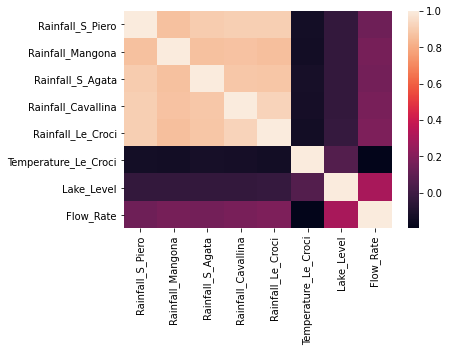

In [35]:
cols = ["Rainfall_S_Piero", "Rainfall_Mangona", "Rainfall_S_Agata", "Rainfall_Cavallina", "Rainfall_Le_Croci",
        "Temperature_Le_Croci", "Lake_Level", "Flow_Rate"]
sns.heatmap(lake_Bilancino[cols].corr())

Unfortunately, no column seems to be highly correlated with Lake_level.

Since we know that Bilancino lake is used differently in summer and winter, we will remove the seasonal component assuming there is a cycle between summer and winter.

>Bilancino lake is an artificial lake located in the municipality of Barberino di Mugello (about 50 km from Florence). It is used to refill the Arno river during the summer months. Indeed, during the winter months, the lake is filled up and then, during the summer months, the water of the lake is poured into the Arno river.

In [36]:
#Assume a 1/2 year cycle.
freq = 182

res_Lake_Level = sm.tsa.seasonal_decompose(lake_Bilancino_Lake_Level["value"].values, period=freq)

lake_Bilancino_Flow_Rate = df_arrange(lake_Bilancino, [col for col in lake_Bilancino.columns if "Flow_Rate" in col])
lake_Bilancino_Flow_Rate = lake_Bilancino_Flow_Rate.fillna(0)
res_Flow_Rate = sm.tsa.seasonal_decompose(lake_Bilancino_Flow_Rate["value"].values, period=freq)

I'll plot the results.
(There are two plots that are the same, but don't worry about it.)

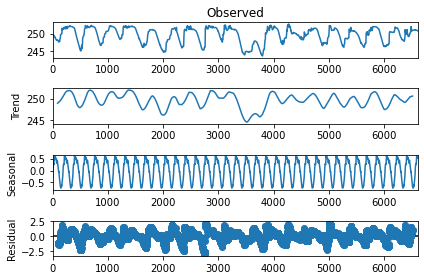

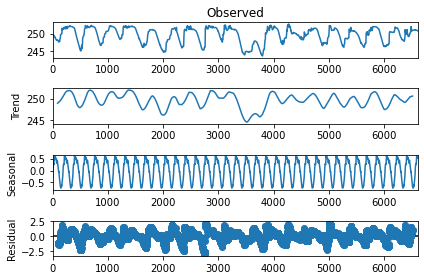

In [37]:
res_Lake_Level.plot()

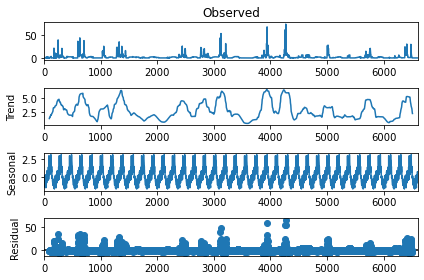

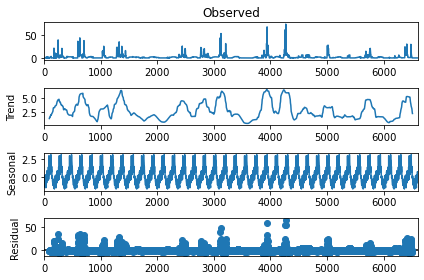

In [38]:
res_Flow_Rate.plot()

In [39]:
lake_Bilancino[["Lake_Level"]] = res_Lake_Level.trend
lake_Bilancino[["Flow_Rate"]] = res_Flow_Rate.trend

----------------------

<a id="7"></a> <br>
# <div class="alert alert-block alert-success">Modeling LightGBM</div>

In the previous section, we have seen what kind of features we can create. In this section, I will put the data into LightBGM and see if we can create a prediction model.

The method will be LightGBM. I use RMSE for evaluation.

In [40]:
from optuna.integration import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

I'll use data of lake Bilancino. If we use too much recent data for input, we will probably have trouble in actual operation, so let's use data that is more than a week old. I'll create lag feature by shift method.

In [41]:
lake_Bilancino = pd.read_csv(DATA + "/" + "Lake_Bilancino.csv")
weather_cols = ["Rainfall_S_Piero", "Rainfall_Mangona", "Rainfall_S_Agata", "Rainfall_Cavallina", "Rainfall_Le_Croci","Temperature_Le_Croci"]
weather_lag7_cols = ["Rainfall_S_Piero_lag7", "Rainfall_Mangona_lag7", "Rainfall_S_Agata_lag7", "Rainfall_Cavallina_lag7", "Rainfall_Le_Croci_lag7","Temperature_Le_Croci_lag7"]
lake_Bilancino[weather_lag7_cols] = lake_Bilancino[weather_cols].shift(7)
lake_Bilancino[["Lake_Level_lag7", "Flow_Rate_lag7"]] = lake_Bilancino[["Lake_Level", "Flow_Rate"]].shift(7)
lake_Bilancino[["Lake_Level_lag14", "Flow_Rate_lag14"]] = lake_Bilancino[["Lake_Level", "Flow_Rate"]].shift(14)
lake_Bilancino[["Lake_Level_lag30", "Flow_Rate_lag30"]] = lake_Bilancino[["Lake_Level", "Flow_Rate"]].shift(30)
lake_Bilancino[["Lake_Level_lag60", "Flow_Rate_lag60"]] = lake_Bilancino[["Lake_Level", "Flow_Rate"]].shift(60)
lake_Bilancino[["Lake_Level_lag90", "Flow_Rate_lag90"]] = lake_Bilancino[["Lake_Level", "Flow_Rate"]].shift(90)
lake_Bilancino.head()

Date  Rainfall_S_Piero  Rainfall_Mangona  Rainfall_S_Agata  \
0  03/06/2002               NaN               NaN               NaN   
1  04/06/2002               NaN               NaN               NaN   
2  05/06/2002               NaN               NaN               NaN   
3  06/06/2002               NaN               NaN               NaN   
4  07/06/2002               NaN               NaN               NaN   

   Rainfall_Cavallina  Rainfall_Le_Croci  Temperature_Le_Croci  Lake_Level  \
0                 NaN                NaN                   NaN      249.43   
1                 NaN                NaN                   NaN      249.43   
2                 NaN                NaN                   NaN      249.43   
3                 NaN                NaN                   NaN      249.43   
4                 NaN                NaN                   NaN      249.44   

   Flow_Rate  Rainfall_S_Piero_lag7  ...  Lake_Level_lag7  Flow_Rate_lag7  \
0       0.31                    NaN  ...              NaN             NaN   
1       0.31                    NaN  ...              NaN             NaN   
2       0.31                    NaN  ...              NaN             NaN   
3       0.31                    NaN  ...              NaN             NaN   
4       0.31                    NaN  ...              NaN             NaN   

   Lake_Level_lag14  Flow_Rate_lag14  Lake_Level_lag30  Flow_Rate_lag30  \
0               NaN              NaN               NaN              NaN   
1               NaN              NaN               NaN              NaN   
2               NaN              NaN               NaN              NaN   
3               NaN              NaN               NaN              NaN   
4               NaN              NaN               NaN              NaN   

   Lake_Level_lag60  Flow_Rate_lag60  Lake_Level_lag90  Flow_Rate_lag90  
0               NaN              NaN               NaN              NaN  
1               NaN              NaN               NaN              NaN  
2               NaN              NaN               NaN              NaN  
3               NaN              NaN               NaN              NaN  
4               NaN              NaN               NaN              NaN  

[5 rows x 25 columns]

I'll predict Lake_Level of lake Bilancino.

In [42]:
cols = ["Rainfall_S_Piero_lag7", "Rainfall_Mangona_lag7", "Rainfall_S_Agata_lag7", "Rainfall_Cavallina_lag7", "Rainfall_Le_Croci_lag7","Temperature_Le_Croci_lag7",
        "Lake_Level_lag7", "Flow_Rate_lag7", "Lake_Level_lag14", "Flow_Rate_lag14", "Lake_Level_lag30", "Flow_Rate_lag30", "Lake_Level_lag60", "Flow_Rate_lag60",
        "Lake_Level_lag90", "Flow_Rate_lag90"]
X = lake_Bilancino[cols]
y = lake_Bilancino["Lake_Level"]

In [43]:
X.columns

Index(['Rainfall_S_Piero_lag7', 'Rainfall_Mangona_lag7',
       'Rainfall_S_Agata_lag7', 'Rainfall_Cavallina_lag7',
       'Rainfall_Le_Croci_lag7', 'Temperature_Le_Croci_lag7',
       'Lake_Level_lag7', 'Flow_Rate_lag7', 'Lake_Level_lag14',
       'Flow_Rate_lag14', 'Lake_Level_lag30', 'Flow_Rate_lag30',
       'Lake_Level_lag60', 'Flow_Rate_lag60', 'Lake_Level_lag90',
       'Flow_Rate_lag90'],
      dtype='object')

Let's create a dataset. I use the first 85% for training and the remaining 15% for prediction.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, 
                                                    shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, 
                                                    shuffle=False)

The model will be LightGBM, tuned with Oputuna.

In [45]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

In [46]:
d_training = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_val, label=y_val)
    
model = lgb.train(params, train_set=d_training, num_boost_round=3000, 
                  valid_sets=[d_training,d_test], verbose_eval=False, early_stopping_rounds=50)

[I 2021-01-09 14:17:05,108] A new study created in memory with name: no-name-454577bf-45ee-4bb6-a62a-5166143659b2
min_data_in_leaf, val_score: 0.336572: 100%|##########| 5/5 [00:00<00:00,  9.74it/s]


The results of training and hyperparameter tuning are shown below.

In [47]:
def print_tuned_params(model):
    print("---------------------")
    print("params:", model.params)
    print("best_iteration:", model.best_iteration)
    print("best_score:", model.best_score)    
    print("---------------------")
    
print_tuned_params(model)

---------------------
params: {'objective': 'regression', 'boosting': 'gbdt', 'num_leaves': 3, 'learning_rate': 0.05, 'feature_fraction': 1.0, 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l2': 2, 'lambda_l1': 0.0, 'bagging_fraction': 0.45474662045563446, 'bagging_freq': 6, 'min_child_samples': 20}
best_iteration: 155
best_score: defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 0.3358343474992834)]), 'valid_1': OrderedDict([('rmse', 0.3365717105630095)])})
---------------------


Now let's estimate the lake level of the last 15% using the model we created.

In [48]:
pred = model.predict(X_test)

idxs = np.array(range(len(pred))) + 1
pred = np.array(pred)

Let's compare the actual data with the estimated values.

Text(0.5, 1.0, 'Comparison of data and prediction results')

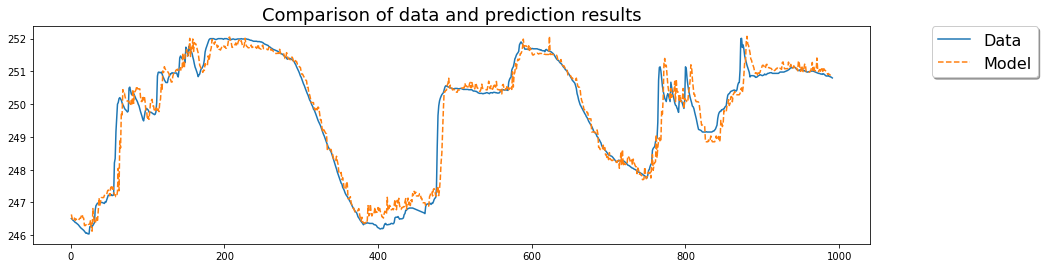

In [49]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(idxs, np.array(y_test), linestyle="solid", label='Data')
ax.plot(idxs, np.array(pred), linestyle="dashed", label='Model')
legend = ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', shadow=True, borderaxespad=0, fontsize=16)
plt.title("Comparison of data and prediction results", fontsize=18)

If we know the values from a week ago, we can predict the lake level with a fair degree of accuracy.

In [50]:
def rmse_without_nan(y_test, pred):
    idxs_not_nan = ~np.isnan(y_test)
    return mean_squared_error(pred[idxs_not_nan], y_test[idxs_not_nan])

In [51]:
print(f"RMSE: {rmse_without_nan(y_test, pred)}")

RMSE: 0.18481922579067064


Let's see the feature importance for reference. Lake level a week ago is the most important. It turns out that temperature one week ago is the next most important factor.

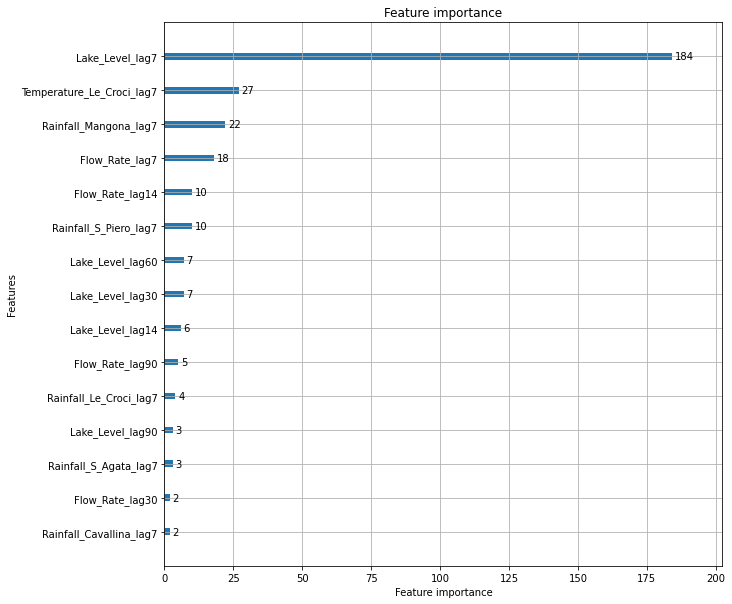

In [52]:
lgb.plot_importance(model, max_num_features=15, figsize=(10,10))
plt.show()

# Reference 

* https://www.usgs.gov/special-topic/water-science-school/science/freshwater-lakes-and-rivers-and-water-cycle?qt-science_center_objects=0#qt-science_center_objects

* https://sswm.info/arctic-wash/module-4-technology/further-resources-water-sources/springs

* https://en.wikipedia.org/wiki/Aquifer

* https://www.usgs.gov/special-topic/water-science-school/science/aquifers-and-groundwater?qt-science_center_objects=0#qt-science_center_objects